In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from scipy.stats import probplot

### Data Collection and Analysis
- We use Yahoo Finance to collect Brent Crude Oil Future (BZ=F) Prices
- From this we calucate the log-returns and volatility.

                                Open       High        Low      Close  Volume  \
Date                                                                            
2023-04-24 00:00:00-04:00  81.599998  82.989998  80.489998  82.730003   16684   
2023-04-25 00:00:00-04:00  82.580002  83.050003  80.349998  80.769997   17134   
2023-04-26 00:00:00-04:00  81.000000  81.470001  77.480003  77.690002   15436   
2023-04-27 00:00:00-04:00  77.870003  78.629997  77.389999  78.370003    8926   
2023-04-28 00:00:00-04:00  78.309998  79.599998  77.970001  79.540001   26788   

                           Dividends  Stock Splits  
Date                                                
2023-04-24 00:00:00-04:00        0.0           0.0  
2023-04-25 00:00:00-04:00        0.0           0.0  
2023-04-26 00:00:00-04:00        0.0           0.0  
2023-04-27 00:00:00-04:00        0.0           0.0  
2023-04-28 00:00:00-04:00        0.0           0.0  


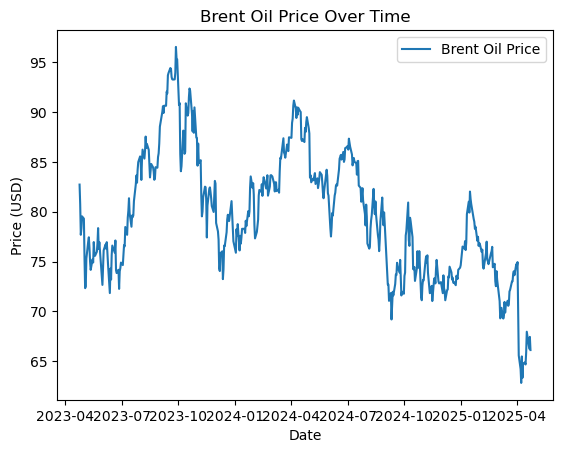

In [ ]:
brent_oil = yf.Ticker("BZ=F")
brent_oil_data = brent_oil.history(
    period="2y", interval="1d", start="2023-04-24", end="2025-04-24"
)
print(brent_oil_data.head())
plt.plot(brent_oil_data.index, brent_oil_data["Close"], label="Brent Oil Price")
plt.title("Brent Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

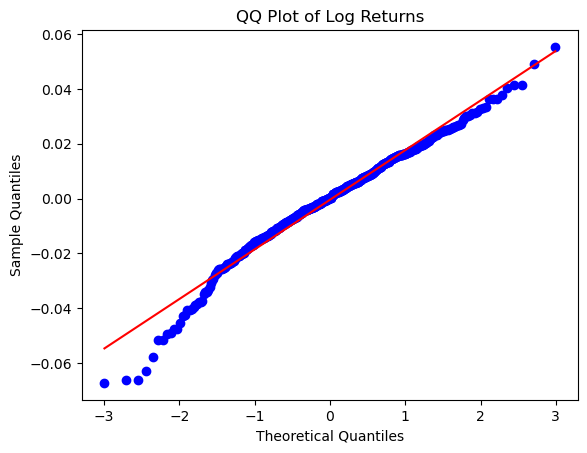

In [3]:
brent_oil_data["Log Returns"] = np.log(
    brent_oil_data["Close"] / brent_oil_data["Close"].shift(1)
)
probplot(brent_oil_data["Log Returns"].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

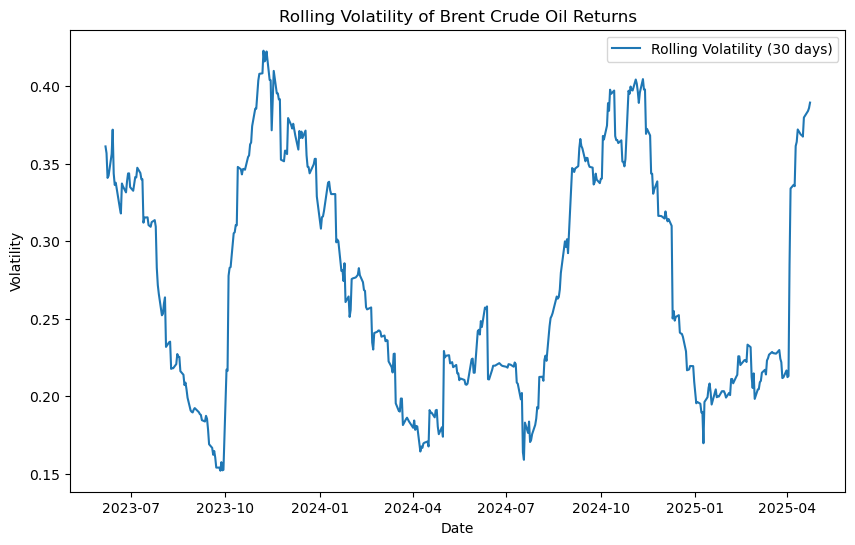

In [4]:
# Calculate rolling volatility with a window size of 30 days
rolling_volatility = brent_oil_data["Log Returns"].rolling(window=30).std() * np.sqrt(
    252
)

# Plot the rolling volatility
plt.figure(figsize=(10, 6))
plt.plot(brent_oil_data.index, rolling_volatility, label="Rolling Volatility (30 days)")
plt.title("Rolling Volatility of Brent Crude Oil Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [ ]:
implied_volatility = brent_oil_data["Log Returns"].std() * np.sqrt(252)
print(f"Annualized Volatility: {implied_volatility:.2%}")
implied_volatility = 0.37042  # source: bloomberg
print(f"Implied Volatility: {implied_volatility:.2%}")

Annualized Volatility: 28.95%
Implied Volatility: 37.04%


### BAPM Pricing Functions

In [6]:
# the following function is used to create a binomial tree for American options
def binomial_tree_regular(S_0, sigma, delta_t, N):
    tree = np.zeros(
        (
            N + 1,
            N + 1,
        )
    )
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    for i in range(N + 1):
        for j in range(i + 1):
            tree[i, j] = S_0 * (u**j) * (d ** (i - j))
    return tree


def generate_asian_nodes(S_0, N, p, u, d):
    # helper function to generate nodes for Asian options
    nodes = {}
    # initial node has time 0, 0 up moves and initial price S_0
    # this also has a probability of 1.0
    nodes[(0, 0, S_0)] = 1.0
    for t in range(1, N + 1):
        new_nodes = {}
        # looping through all the existing nodes in the tree
        for (prev_t, up_moves, cum_sum), prob in nodes.items():
            down_moves = prev_t - up_moves
            # calculating the new up and down prices
            S_up = S_0 * (u ** (up_moves + 1)) * (d**down_moves)
            S_down = S_0 * (u**up_moves) * (d ** (down_moves + 1))
            # updating new nodes with the new up and down prices
            key_up = (t, up_moves + 1, cum_sum + S_up)
            new_nodes[key_up] = new_nodes.get(key_up, 0) + prob * p
            key_down = (t, up_moves, cum_sum + S_down)
            new_nodes[key_down] = new_nodes.get(key_down, 0) + prob * (1 - p)
        nodes = new_nodes
    return nodes


def prob_p(r_f, delta_t, sigma):
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp(r_f * delta_t) - d) / (u - d)
    return p, u, d


def asian_option_valuation(S_0, K, r_f, sigma, T, N, option_type):
    delta_t = T / N
    p, u, d = prob_p(r_f, delta_t, sigma)
    tree_nodes = generate_asian_nodes(S_0, N, p, u, d)
    option_value = 0
    for (t, up_moves, cum_sum), prob in tree_nodes.items():
        # calculating average price at each node
        avg_price = cum_sum / (N + 1)
        if option_type == "call":
            option_value += prob * np.maximum(avg_price - K, 0)
        elif option_type == "put":
            option_value += prob * np.maximum(K - avg_price, 0)
    option_value *= np.exp(-r_f * T)
    return option_value

In [33]:
T = 1
S0 = brent_oil_data.iloc[0]["Close"]
sigma = implied_volatility
r = 4.12 / 100  # 2-year treasury note yield on 2023-04-24 from FRED
n_sims = 100000
n_steps = 25
K = int(S0)
asian_option_valuation(S0, K, r, sigma, T, n_steps, "call")

np.float64(8.025403033256218)

### Monte Carlo Simulation

In [34]:
def get_paths(S0, T, sigma, r, n_sims, n_steps):
    # Vectorized for efficiency
    dt = T / n_steps
    dZ_matrix = np.random.normal(size=(n_steps, n_sims))
    log_returns = sigma * np.sqrt(dt) * dZ_matrix + ((r - ((sigma**2) / 2)) * dt)
    log_init_price = np.full((1, n_sims), np.log(S0))
    log_prices = np.cumsum(
        np.concatenate((log_init_price, log_returns), axis=0), axis=0
    )
    paths = np.exp(log_prices)
    return paths


def plot_paths(paths, dt, title):
    num_steps = paths.shape[0]
    num_paths = paths.shape[1]
    timesteps = dt * np.arange(num_steps)

    cmap = plt.get_cmap("gist_ncar", num_paths)
    _, ax = plt.subplots()
    for i in range(num_paths):
        color = cmap(i) if num_paths > 1 else "blue"

        ax.plot(timesteps, paths[:, i], color=color, linewidth=0.5)

    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Price")
    ax.set_title(title)
    ax.grid(True)
    plt.show()


def plot_payoffs(payoffs, opt_type):
    mean_payoff = np.mean(payoffs)
    nonzero_payoffs = np.delete(payoffs, np.where(payoffs == 0))
    plt.figure()
    plt.hist(nonzero_payoffs, bins="auto")
    plt.xlabel("Payoff (USD)")
    if opt_type == "call":
        plt.title("Non-Zero, Non-Discounted Simulated Call Option Payoffs")
    elif opt_type == "put":
        plt.title("Non-Zero, Non-Discounted Simulated Put Option Payoffs")
    plt.axvline(
        x=mean_payoff,
        label="Mean Payoff Including Zeros",
        color="black",
        linestyle="--",
    )
    plt.legend()
    plt.show()


def price_asian_option(
    S0,
    T,
    sigma,
    r,
    n_sims,
    n_steps,
    K,
    opt_type,
    average_method,
    show_paths=False,
    show_payoffs=False,
):
    # Vectorized for efficiency
    paths = get_paths(S0, T, sigma, r, n_sims, n_steps)
    if show_paths:
        plot_paths(paths, T / n_steps, "Price Paths")
    # ignore initial spot price
    if average_method == "arithmetic":
        average_prices = np.mean(paths[1:,], axis=0)
    elif average_method == "geometric":
        average_prices = np.exp(np.mean(np.log(paths[1:,]), axis=0))
    payoffs = None
    if opt_type == "call":
        payoffs = np.maximum(average_prices - K, 0)
    elif opt_type == "put":
        payoffs = np.maximum(K - average_prices, 0)
    else:
        raise Exception("invalid option type")

    if show_payoffs:
        plot_payoffs(payoffs, opt_type)

    mean_payoff = np.mean(payoffs)
    discounted_mean_payoff = mean_payoff * np.exp(-1 * r * T)
    return discounted_mean_payoff

### Try with the parameters in the Linetsky Paper

In [27]:
rates = [0.02, 0.18, 0.0125, 0.05, 0.05, 0.05, 0.05]
sigmas = [0.1, 0.3, 0.25, 0.5, 0.5, 0.5, 0.5]
times = [1, 1, 2, 1, 1, 1, 2]
spots = [2, 2, 2, 1.9, 2, 2.1, 2]
taos = [0.0025, 0.0225, 0.03125, 0.0625, 0.0625, 0.0625, 0.125]
K = 2
v = [
    (2 * rates[i] / (sigmas[i] ** 2)) - 1 for i in range(len(rates))
]  # this matches the table, indicating zero dividends
true_prices = [
    0.0559860415,
    0.2183875466,
    0.1722687410,
    0.1931737903,
    0.2464156905,
    0.3062203648,
    0.3500952190,
]
n_sims = 100000

prices = []
for i in range(len(rates)):
    n_steps = int(times[i] * 252)
    call_price = price_asian_option(
        S0=spots[i],
        T=times[i],
        sigma=sigmas[i],
        r=rates[i],
        n_sims=n_sims,
        n_steps=n_steps,
        K=K,
        average_method="arithmetic",
        opt_type="call",
    )
    prices.append(call_price)

prices = np.array(prices)
errors = np.array(true_prices) - prices
print(prices)
print(errors)

[0.05602263 0.21867368 0.17260302 0.19272031 0.2480082  0.3092854
 0.34579833]
[-3.65848005e-05 -2.86128561e-04 -3.34279300e-04  4.53482273e-04
 -1.59250586e-03 -3.06503875e-03  4.29689238e-03]


### Price Asian Options on Brent Crude Oil Futures

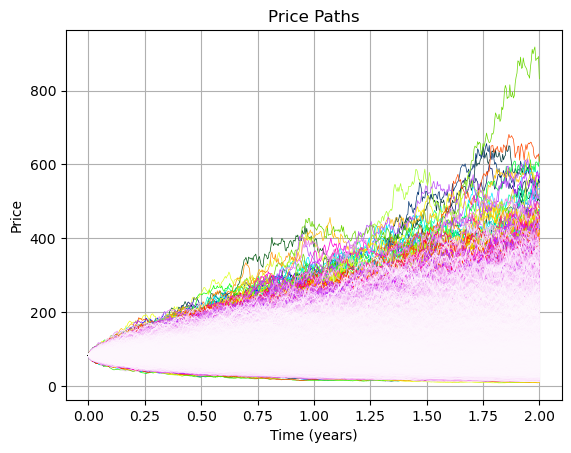

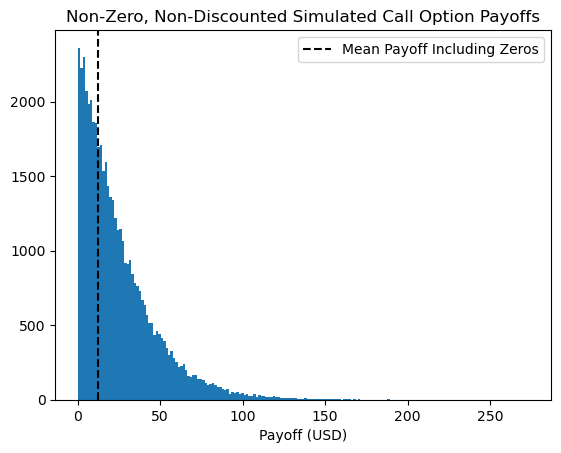

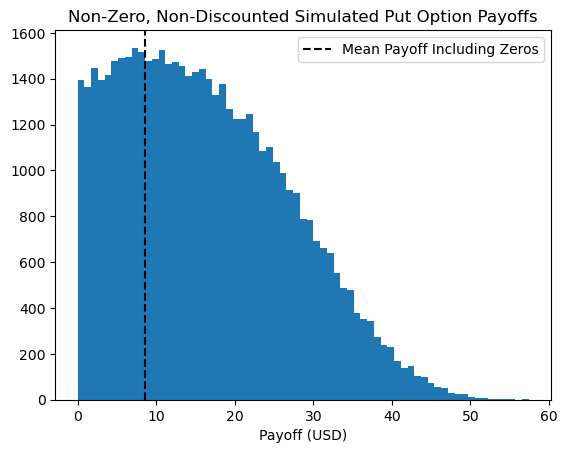

Call Price: 11.062705053292232
Put Price: 7.830865483710699



In [38]:
T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = implied_volatility
r = 4.12 / 100  # 2-year treasury note yield on 2023-04-24 from FRED
n_sims = 100000
n_steps = 252 * T
K = S0

call_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="call",
    average_method="arithmetic",
    show_paths=True,
    show_payoffs=True,
)
put_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="put",
    average_method="arithmetic",
    show_paths=False,
    show_payoffs=True,
)

print(f"Call Price: {call_price}")
print(f"Put Price: {put_price}")
print(f"")

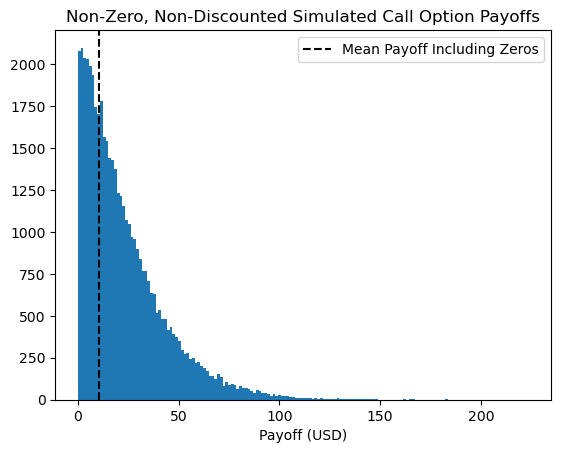

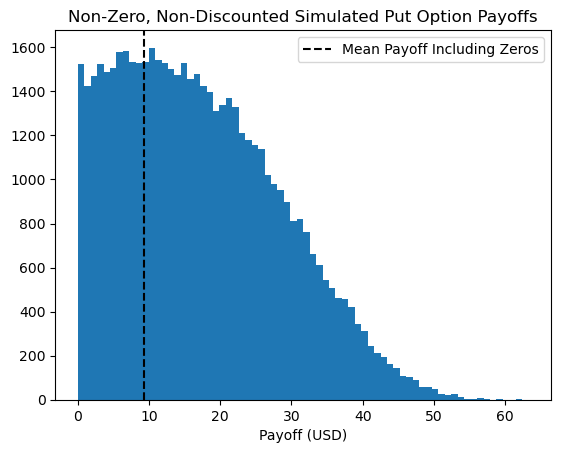

Call Price: 9.9003538450159
Put Price: 8.576456688745724



In [37]:
T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = implied_volatility
r = 4.12 / 100  # 2-year treasury note yield on 2023-04-24 from FRED
n_sims = 100000
n_steps = T * 252
K = S0

call_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="call",
    average_method="geometric",
    show_paths=False,
    show_payoffs=True,
)
put_price = price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="put",
    average_method="geometric",
    show_paths=False,
    show_payoffs=True,
)

print(f"Call Price: {call_price}")
print(f"Put Price: {put_price}")
print(f"")

### To hedge our Asian Options, we need to use the Greeks.

However, for our example, since we are not working with European options, we need to take a different approach to pricing greeks.

In [ ]:
def calculate_price_greeks(S0, K, r, sigma, T, n_steps, n_sims, option_type, epsilon=1):
    if option_type == "call":
        price = price_asian_option(
            S0=S0,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
            average_method="arithmetic",
        )
        call_price_up = price_asian_option(
            S0=S0 + epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
            average_method="arithmetic",
        )
        call_price_down = price_asian_option(
            S0=S0 - epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="call",
            average_method="arithmetic",
        )
        delta = (call_price_up - call_price_down) / (2 * epsilon)
        gamma = (call_price_up - 2 * price + call_price_down) / (epsilon**2)
    elif option_type == "put":
        price = price_asian_option(
            S0=S0,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
            average_method="arithmetic",
        )
        put_price_up = price_asian_option(
            S0=S0 + epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
            average_method="arithmetic",
        )
        put_price_down = price_asian_option(
            S0=S0 - epsilon,
            T=T,
            sigma=sigma,
            r=r,
            n_sims=n_sims,
            n_steps=n_steps,
            K=K,
            opt_type="put",
            average_method="arithmetic",
        )
        delta = (put_price_up - put_price_down) / (2 * epsilon)
        gamma = (put_price_up - 2 * price + put_price_down) / (epsilon**2)
    return delta, gamma


T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = implied_volatility
r = 4.12 / 100  # 2-year treasury note yeild on 2023-04-24 from FRED
n_sims = 1000000
n_steps = T * 252
K = int(S0)
epsilon = S0 * 0.01

delta_call, gamma_call = calculate_price_greeks(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_sims=n_sims,
    option_type="call",
    epsilon=epsilon,
)
delta_put, gamma_put = calculate_price_greeks(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_sims=n_sims,
    option_type="put",
    epsilon=epsilon,
)
print(f"Call Option Delta: {delta_call:.4f}, Gamma: {gamma_call:.4f}")
print(f"Put Option Delta: {delta_put:.4f}, Gamma: {gamma_put:.4f}")

Call Option Delta: 0.6060, Gamma: 0.0327
Put Option Delta: -0.3701, Gamma: -0.0035


### Closed-Form Result of Black-Scholes Model

In [ ]:
from scipy.stats import norm


def geometric_asian_option__bs(S_0, K, r, sigma, T, option_type, q=0):
    G_0 = S_0 * np.exp(1 / 2 * (r - q) * T - 1 / 12 * sigma**2 * T)
    sigma_g = 1 / np.sqrt(3) * sigma
    d1_g = 1 / (sigma_g * np.sqrt(T)) * (np.log(G_0 / K) + (0.5 * sigma_g**2) * T)
    d2_g = 1 / (sigma_g * np.sqrt(T)) * (np.log(G_0 / K) - (0.5 * sigma_g**2) * T)
    G_c = np.exp(-r * T) * (G_0 * norm.cdf(d1_g) - K * norm.cdf(d2_g))
    G_p = np.exp(-r * T) * (K * norm.cdf(-d2_g) - G_0 * norm.cdf(-d1_g))
    if option_type == "call":
        return G_c
    elif option_type == "put":
        return G_p


def geometric_asian_option_delta(S_0, K, r, sigma, T, option_type, q=0):
    G_0 = S_0 * np.exp(1 / 2 * (r - q) * T - 1 / 12 * sigma**2 * T)
    sigma_g = 1 / np.sqrt(3) * sigma
    d1_g = 1 / (sigma_g * np.sqrt(T)) * (np.log(G_0 / K) + (0.5 * sigma_g**2) * T)
    if option_type == "call":
        return norm.cdf(d1_g)
    elif option_type == "put":
        return norm.cdf(-d1_g)

In [ ]:
rates = [0.02, 0.18, 0.0125, 0.05, 0.05, 0.05, 0.05]
sigmas = [0.1, 0.3, 0.25, 0.5, 0.5, 0.5, 0.5]
times = [1, 1, 2, 1, 1, 1, 2]
spots = [2, 2, 2, 1.9, 2, 2.1, 2]
K = 2

n_sims = 100000
b_s_prices = []
for x in range(len(rates)):
    call_price = geometric_asian_option__bs(
        S_0=spots[x],
        K=K,
        r=rates[x],
        sigma=sigmas[x],
        T=times[x],
        option_type="call",
    )
    b_s_prices.append(call_price)


prices = []
for i in range(len(rates)):
    n_steps = int(times[i] * 252)
    call_price = price_asian_option(
        S0=spots[i],
        T=times[i],
        sigma=sigmas[i],
        r=rates[i],
        n_sims=n_sims,
        n_steps=n_steps,
        K=K,
        average_method="geometric",
        opt_type="call",
    )
    prices.append(call_price)

prices = np.array(prices)
errors = np.array(b_s_prices) - prices
print(f"Monte Carlo Geometric Simulation of Prices {prices}")
print(f"Black Scholes Geometric Prices {b_s_prices}")
print(f"Monte Carlo and Black Scholes Geometric Error  {errors}")

Monte Carlo Geometric Simulation of Prices [0.05504583 0.20552383 0.16115804 0.17469739 0.22362509 0.28027469
 0.30321235]
Black Scholes Geometric Prices [0.054952094869989455, 0.20542303569544912, 0.16077854922195098, 0.1723399145719022, 0.2227879316100565, 0.27974266392421687, 0.3015600627137399]
Monte Carlo and Black Scholes Geometric Error  [-9.37314101e-05 -1.00798624e-04 -3.79490255e-04 -2.35747872e-03
 -8.37158255e-04 -5.32030601e-04 -1.65229028e-03]


## Hedging exercise

In [ ]:
def generate_stock_prices(S0, mu, sigma, T, n_steps):
    # implementing geometric brownian motion to generate prices
    dt = T / n_steps
    prices = [S0]
    for _ in range(n_steps - 1):
        dW = np.random.normal(0, np.sqrt(dt))
        S_t = prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
        prices.append(S_t)
    return prices


def bs_asian_delta(S_0, K, r, sigma, T, option_type, q=0):
    G_0 = S_0 * np.exp(1 / 2 * (r - q) * T - 1 / 12 * sigma**2 * T)
    sigma_g = 1 / np.sqrt(3) * sigma
    d1_g = 1 / (sigma_g * np.sqrt(T)) * (np.log(G_0 / K) + (0.5 * sigma_g**2) * T)
    if option_type == "call":
        return norm.cdf(d1_g)
    elif option_type == "put":
        return norm.cdf(-d1_g)

In [ ]:
T = 2
S0 = brent_oil_data.iloc[0]["Close"]
sigma = implied_volatility
r = 4.12 / 100  # 2-year treasury note yield on 2023-04-24 from FRED
K = int(S0)
geometric_asian_option__bs(S_0=S0, K=K, r=r, sigma=sigma, T=T, option_type="call")

8.705641520931366

In [ ]:
price_asian_option(
    S0=S0,
    T=T,
    sigma=sigma,
    r=r,
    n_sims=n_sims,
    n_steps=n_steps,
    K=K,
    opt_type="call",
    average_method="geometric",
)

8.747946611812798

Timestep 0
Black Scholes Price: 0.5107
Delta: 0.5044
Asset Price: 100.0000
Timestep 1
Black Scholes Price: 0.3765
Delta: 0.4132
Asset Price: 99.7074
Timestep 2
Black Scholes Price: 0.3596
Delta: 0.4005
Asset Price: 99.6659
Timestep 3
Black Scholes Price: 0.0432
Delta: 0.0772
Asset Price: 98.1901
Timestep 4
Black Scholes Price: 0.2379
Delta: 0.2990
Asset Price: 99.3171
Timestep 5
Black Scholes Price: 0.0355
Delta: 0.0653
Asset Price: 98.0805
Timestep 6
Black Scholes Price: 0.0112
Delta: 0.0242
Asset Price: 97.5042
Timestep 7
Black Scholes Price: 0.0226
Delta: 0.0445
Asset Price: 97.8443
Timestep 8
Black Scholes Price: 0.0035
Delta: 0.0085
Asset Price: 96.9961
Timestep 9
Black Scholes Price: 0.0005
Delta: 0.0015
Asset Price: 96.2809


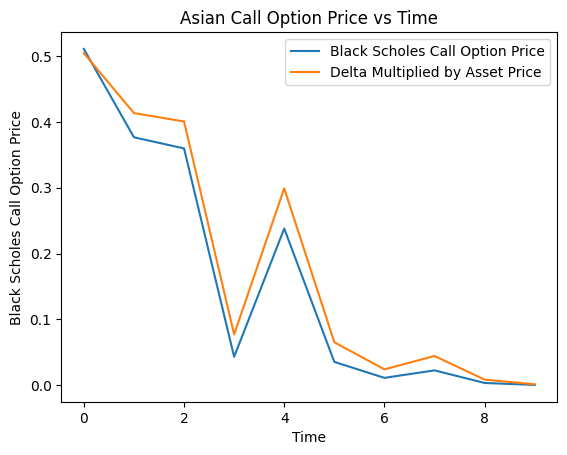

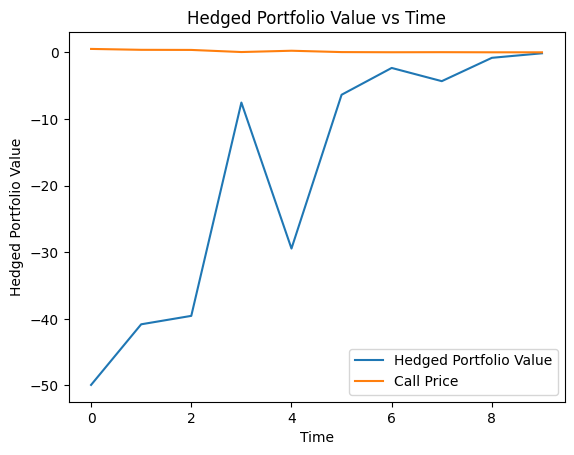

In [ ]:
np.random.seed(2)  # for reproducibility
S0 = 100
mu = 0.00
sigma = 0.35
T = 1 / 252
n_steps = 10
daily_prices = generate_stock_prices(S0, mu, sigma, T, n_steps)
k = 100
call_prices = []
deltas = []
for x in range(len(daily_prices)):
    print(f"Timestep {x}")
    black_scholes_price = geometric_asian_option__bs(
        S_0=daily_prices[x],
        K=k,
        r=r,
        sigma=sigma,
        T=T,
        option_type="call",
    )
    delta = bs_asian_delta(
        S_0=daily_prices[x],
        K=k,
        r=r,
        sigma=sigma,
        T=T,
        option_type="call",
    )
    deltas.append(delta)
    call_prices.append(black_scholes_price)
    print(f"Black Scholes Price: {black_scholes_price:.4f}")
    print(f"Delta: {delta:.4f}")
    print(f"Asset Price: {daily_prices[x]:.4f}")
plt.plot(call_prices, label="Black Scholes Call Option Price")
plt.plot(deltas, label="Delta Multiplied by Asset Price")
plt.legend()
plt.title("Asian Call Option Price vs Time")
plt.xlabel("Time")
plt.ylabel("Black Scholes Call Option Price")
plt.show()


# hedged portfolio
difference = np.array(call_prices) - np.array(deltas) * np.array(daily_prices)
plt.plot(difference, label="Hedged Portfolio Value")
plt.plot(call_prices, label="Call Price")
plt.legend()
plt.title("Hedged Portfolio Value vs Time")
plt.xlabel("Time")
plt.ylabel("Hedged Portfolio Value")
plt.show()

We can see that the hedge always goes to 0 and converges there. We also see that the hedged portfolio value has the least variability which is important to note. This is because we are hedging all of our upside and downside.

### Simulating 2 Year Time period

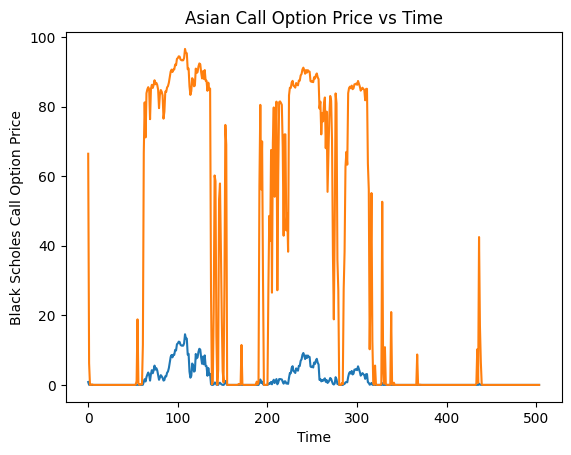

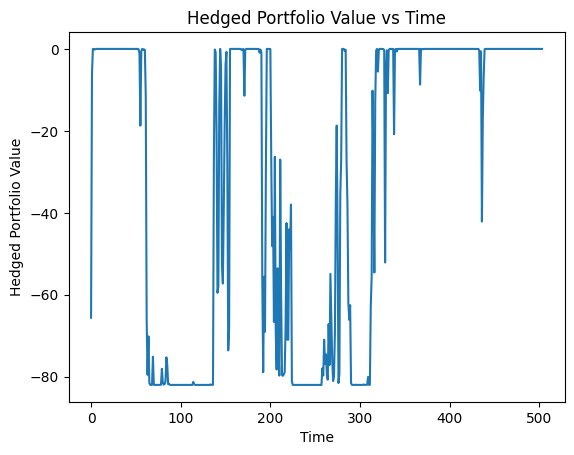

In [ ]:
S0 = brent_oil_data.iloc[0]["Close"]
mu = 0.0412
sigma = implied_volatility
T = 1 / 252
n_steps = 504
K = int(S0)
deltas = []
call_prices = []
new_prices = brent_oil_data["Close"].values
for x in range(len(new_prices)):
    black_scholes_price = geometric_asian_option__bs(
        S_0=new_prices[x],
        K=K,
        r=r,
        sigma=sigma,
        T=T,
        option_type="call",
    )
    delta = bs_asian_delta(
        S_0=new_prices[x],
        K=K,
        r=r,
        sigma=sigma,
        T=T,
        option_type="call",
    )
    deltas.append(delta * new_prices[x])
    call_prices.append(black_scholes_price)
plt.plot(call_prices, label="Black Scholes Call Option Price")
plt.plot(deltas, label="Delta")
plt.plot()
plt.title("Asian Call Option Price vs Time")
plt.xlabel("Time")
plt.ylabel("Black Scholes Call Option Price")
plt.show()


# hedged portfolio
difference = np.array(call_prices) - np.array(deltas)
plt.plot(difference)
plt.title("Hedged Portfolio Value vs Time")
plt.xlabel("Time")
plt.ylabel("Hedged Portfolio Value")
plt.show()